# Обучение с учителем: качество модели. Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность в интернет-магазин «В один клик»

# Описание проекта
Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. Нужно разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

[**Шаг 1. Загрузка данных**](#step_01)

Шаг 2. Предобработка данных

Шаг 3. Исследовательский анализ

Шаг 4. Объединение таблиц

Шаг 5. Корреляционный анализ

Шаг 6. Использование пайплайнов

# Шаг 1. Загрузка данных


In [183]:
# ! conda install -y numpy'>=1.22 <=1.26'
# ! pip install shap 

In [184]:
#импорт необходимых библиотек 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
from scipy import stats
import seaborn as sns
from typing import List
from scipy.stats import shapiro
import warnings


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import pandas as pdfrom 
from sklearn.compose import ColumnTransformer

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_auc_score
import shap

In [185]:
! pip install -U scikit-learn

In [186]:
try:
    df_market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
    df_market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
    df_market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv', decimal=',')
    df_money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep = ';', decimal=',')
except Exception:
    print('Упc, кажется такого файла нет')

In [187]:
df_market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [188]:
df_market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


В датафрейме есть следующие столбцы
* **Покупательская активность** — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».

* **Тип сервиса** — уровень сервиса, например «премиум» и «стандарт».

* **Разрешить сообщать** — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.

* **Маркет_актив_6_мес** — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.

* **Маркет_актив_тек_мес** — количество маркетинговых коммуникаций в текущем месяце.

* **Длительность** — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.

* **Акционные_покупки** — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.

* **Популярная_категория** — самая популярная категория товаров у покупателя за последние 6 месяцев.

* **Средний_просмотр_категорий_за_визит** — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.

* **Неоплаченные_продукты_штук_квартал** — общее число неоплаченных товаров в корзине за последние 3 месяца.

* **Ошибка_сервиса** — число сбоев, которые коснулись покупателя во время посещения сайта.

* **Страниц_за_визит** — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Изучим данные df_market_money

In [189]:
df_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [190]:
df_market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


В датафейме есть следующие столбцы

* **id** — номер покупателя в корпоративной базе данных.

* **Период** — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.

* **Выручка** — сумма выручки за период.

Изучим даннные df_market_time

In [191]:
df_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [192]:
df_market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


В датафрейме есть следующие столбцы
* **id** — номер покупателя в корпоративной базе данных.

* **Период** — название периода, во время которого зафиксировано общее время.

* **минут** — значение времени, проведённого на сайте, в минутах.

Изучим df_money

In [193]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [194]:
df_money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


# Шаг 2. Предобработка данных

In [195]:
#проверим дубликаты. Если дубликаты есть - удалим их 
data_frame = [df_market_file, df_market_money, df_market_time, df_money]

for data in data_frame:
    data_name = [key for key, value in locals().items() if value is data][0]
    print(f'Количество дубликатов в датафрейме {data_name}: {data.duplicated().sum()}')
    if data.duplicated().sum() > 0:
        data.drop_duplicates(inplace=True)
        #создаем словарь, где ключ - название переменной, чтобы название переменной передать в f-строку
        data_name = [key for key, value in locals().items() if value is data][0]
        print(f'Количество дубликатов в датафрейме {data_name}: {data.duplicated().sum()}')

Количество дубликатов в датафрейме df_market_file: 0
Количество дубликатов в датафрейме df_market_money: 0
Количество дубликатов в датафрейме df_market_time: 0
Количество дубликатов в датафрейме df_money: 0


Проверим неявные дубликаты. Если они есть - заменим 

In [196]:
print('df_market_file')
columns = ['Покупательская активность', 'Тип сервиса', 'Популярная_категория', ]
def duplicates(columns, df):
    for column in columns:
        unique_values = df[column].unique()
        print(f'Уникальные значения в колонке {column}: {unique_values}')
duplicates(columns, df_market_file)
print()
print('df_market_money')
columns = ['Период']
duplicates(columns, df_market_money)
print()
print('df_market_time')
duplicates(columns, df_market_time)


df_market_file
Уникальные значения в колонке Покупательская активность: ['Снизилась' 'Прежний уровень']
Уникальные значения в колонке Тип сервиса: ['премиум' 'стандартт' 'стандарт']
Уникальные значения в колонке Популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

df_market_money
Уникальные значения в колонке Период: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

df_market_time
Уникальные значения в колонке Период: ['текущий_месяц' 'предыдцщий_месяц']


In [197]:
df_market_file['Тип сервиса'] = df_market_file['Тип сервиса'].replace('стандартт','стандарт')

In [198]:
df_market_time['Период'] = df_market_time['Период'].replace('предыдцщий_месяц','предыдущий_месяц')

Пропуски

In [199]:
#проверим пропуски. Если они есть - изучим. Если нет - пойдем дальше
for data in data_frame:
    data_name = [key for key, value in locals().items() if value is data][0]
    print(f'прошущенные значения в {data_name}:\n{data.isnull().sum().sort_values()}')
    print()

прошущенные значения в df_market_file:
id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

прошущенные значения в df_market_money:
id         0
Период     0
Выручка    0
dtype: int64

прошущенные значения в df_market_time:
id        0
Период    0
минут     0
dtype: int64

прошущенные значения в df_money:
id         0
Прибыль    0
dtype: int64



# Вывод 
1) Пропусков и дубликатов в датафрйемах не обнаружено
2) Неявные дубликаты, которые возникли из-за опечаток, устранили 

# Шаг 3. Исследовательский анализ данных

In [200]:
def create_histogram(data, column,bins=50):
    """
    Input:
    - data: Датафрейм, содержащий данные.
    - column: Наименование столбца, для которого нужно построить гистограмму.
    - title: Заголовок гистограммы.
    - bins: Количество бинов для гистограммы (по умолчанию 50)

     Output:
    - None

     Description:
    Функция создает гистограмму для указанного столбца в датафрейме при помощи библиотеки seaborn. 
    Результат выводится на экран.
      """
    plt.figure(figsize=(12, 6))
    sns.set()
    sns.histplot(data=data, x=column, kde=True, bins=bins)
    plt.title(f'{column} - Плотность распределения', fontsize=18)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.show()

In [201]:
def create_barplot(data, column):
    """
    Input:
    - data (DataFrame): Исходный DataFrame с данными.
    - column (str): Название колонки, для которой нужно построить диаграмму.
    - title (str): Заголовок для столбчатой диаграммы.
    
    Output:
    None

    Description:
    Функция создает столбчатую диаграмму на основе данных из указанной колонки.
    """
    plt.figure(figsize=(10, 6))
    new_data = data[column].value_counts()
    df_new_data = new_data.reset_index()
    df_new_data.columns = [column, 'count']
    sns.barplot(x=column, y='count', data = df_new_data)
    plt.title(f'{column}.Плотность распределения')
    plt.xlabel(f'{column}')
    plt.ylabel(f'количество {column}')

In [202]:
def cat_num_col(df):
    """
    Input:
    - df(DataDrame): Исходный DataFrame с данными
    Output:
    - num_col_names(list) - список столбцов с количественными признаками
    - cat_col_names(list) - список столбцов с категориальными признаками

    Description:
    Функция возвращает списки с названиями столбцов категориальных и количественных признаков. id из списка удаляется

    """
    num_col_names = list(df.select_dtypes(include=['int64', 'float64']).columns)
    cat_col_names = list(df.select_dtypes(include=['object']).columns)
    num_col_names.remove('id')
    return num_col_names, cat_col_names


df_market_file

In [203]:
df_market_file.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
Маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
Маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
Длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
Акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
Средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
Неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
Ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
Страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


In [204]:
num_col_names_market, cat_col_names_market = cat_num_col(df_market_file)

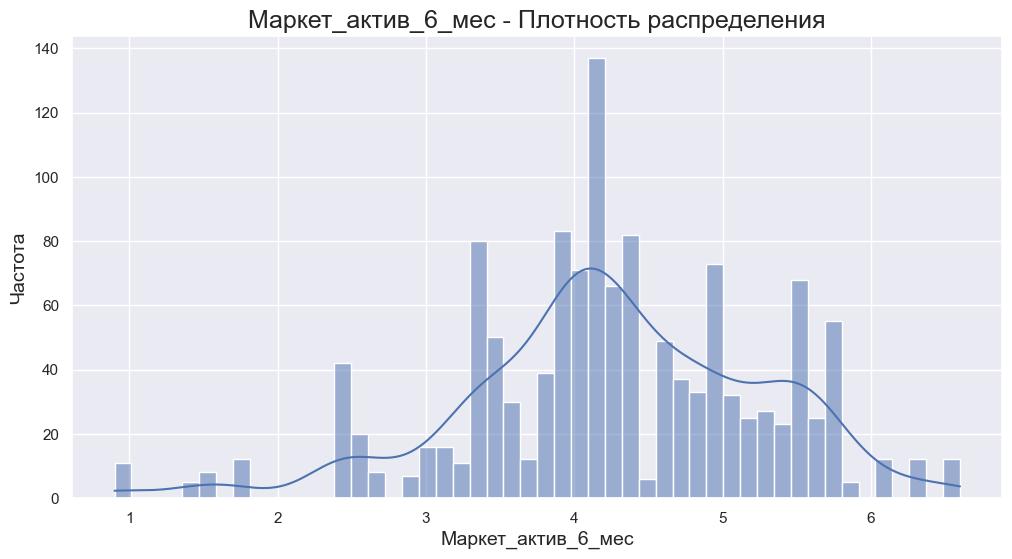

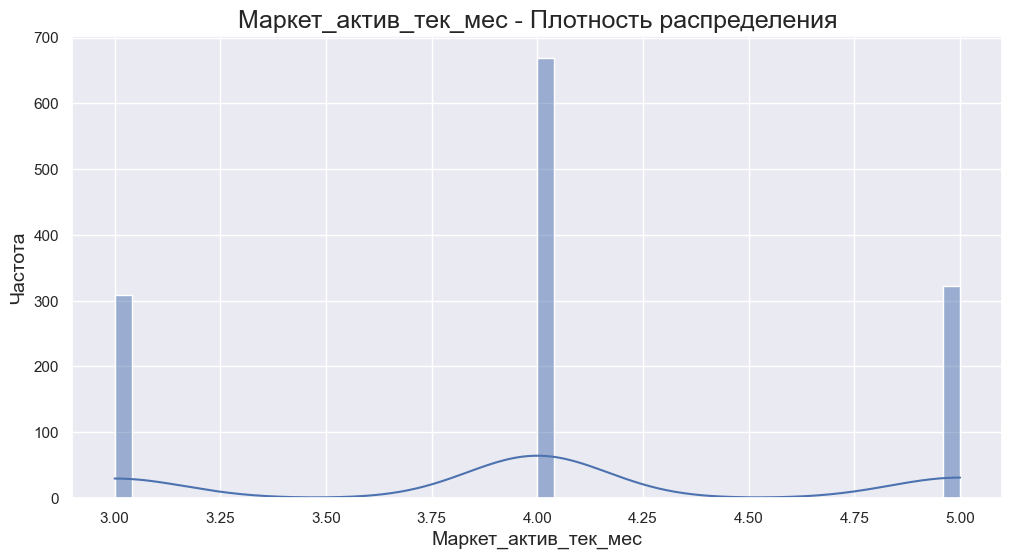

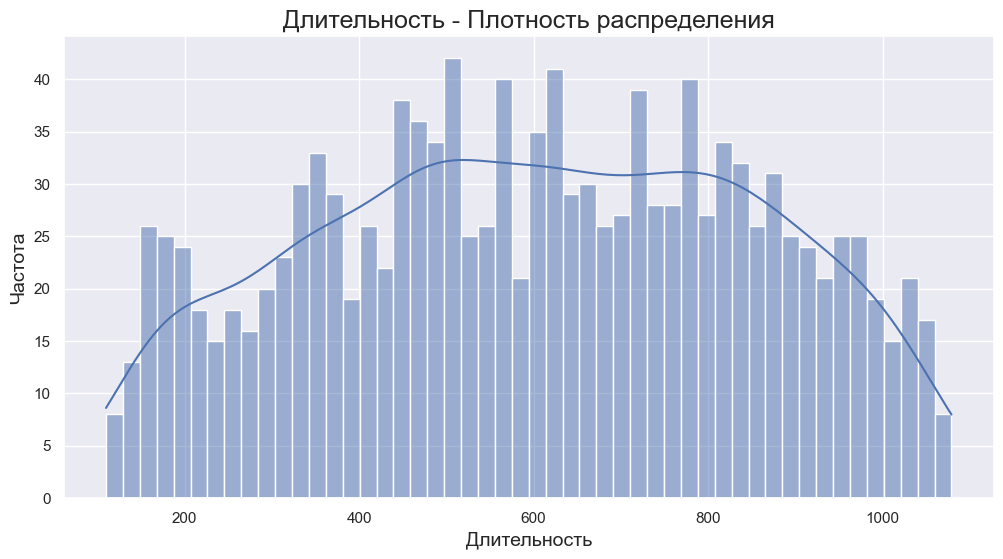

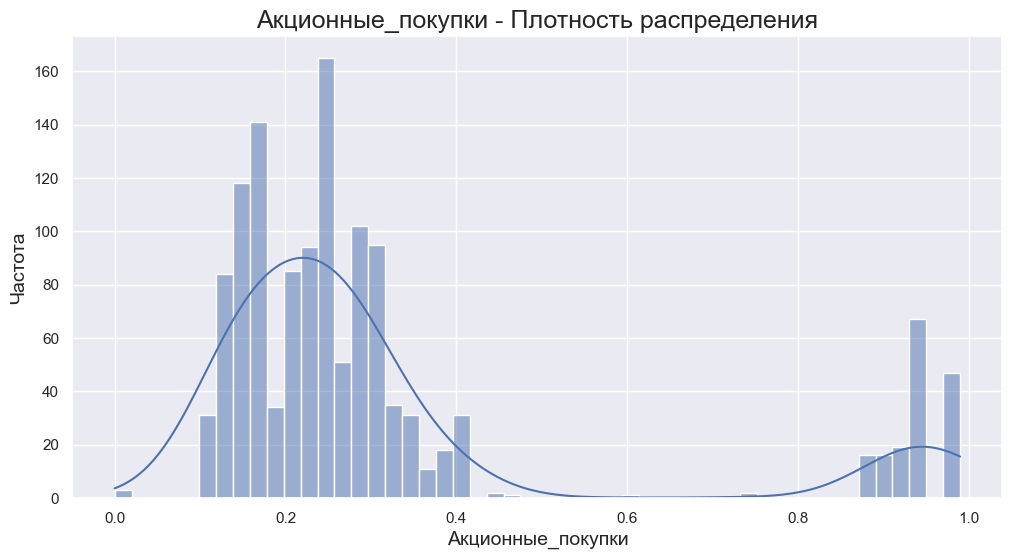

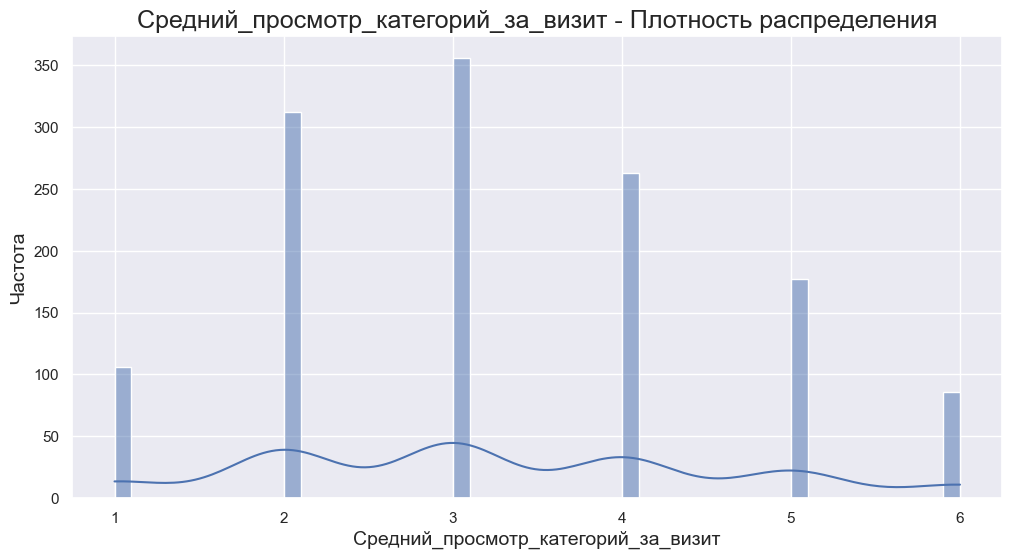

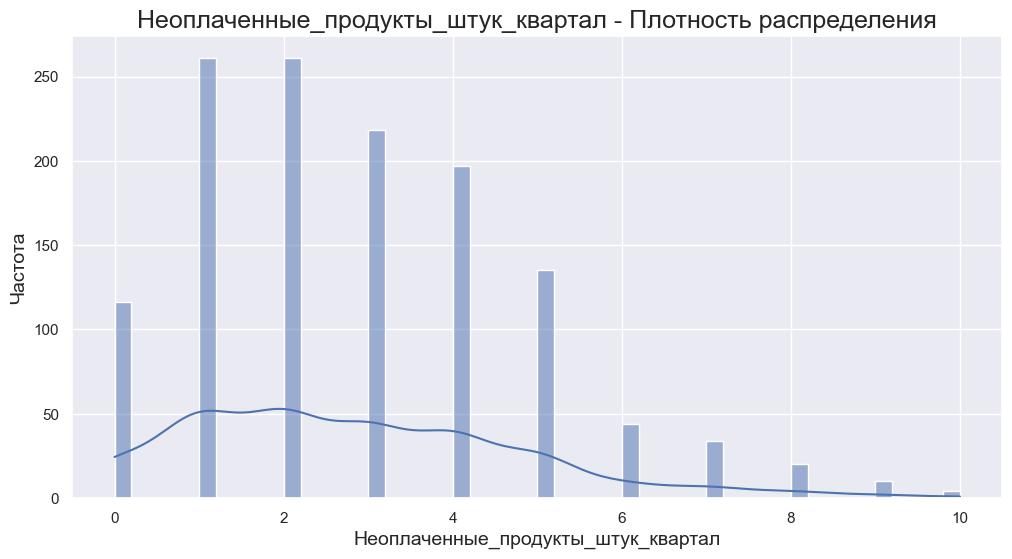

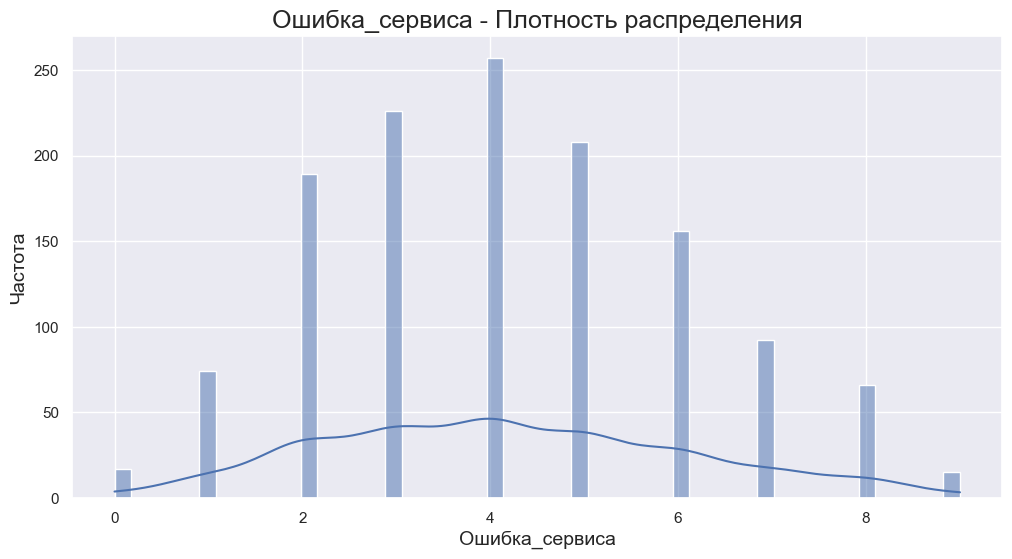

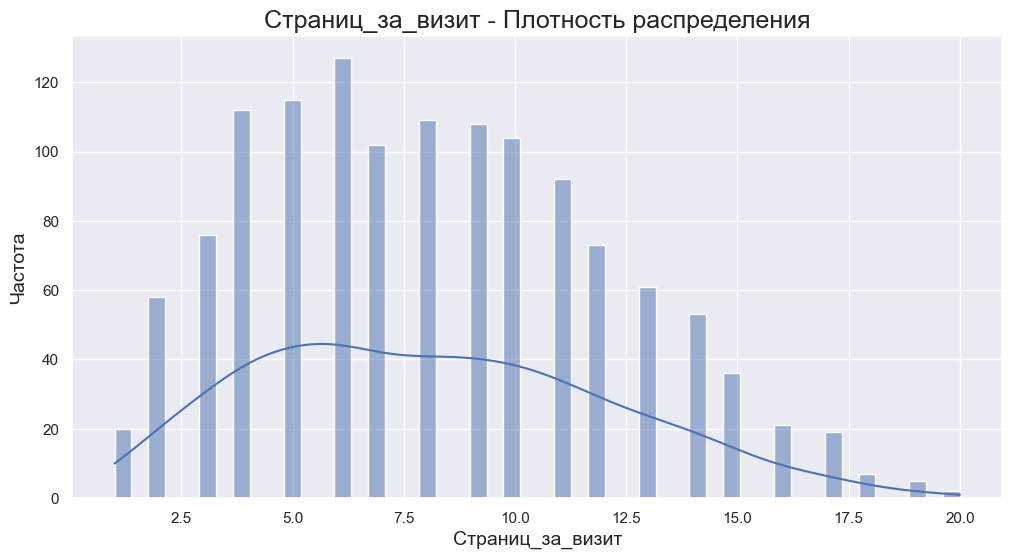

In [205]:
for num_name in num_col_names_market:
    create_histogram(df_market_file, num_name,bins=50)

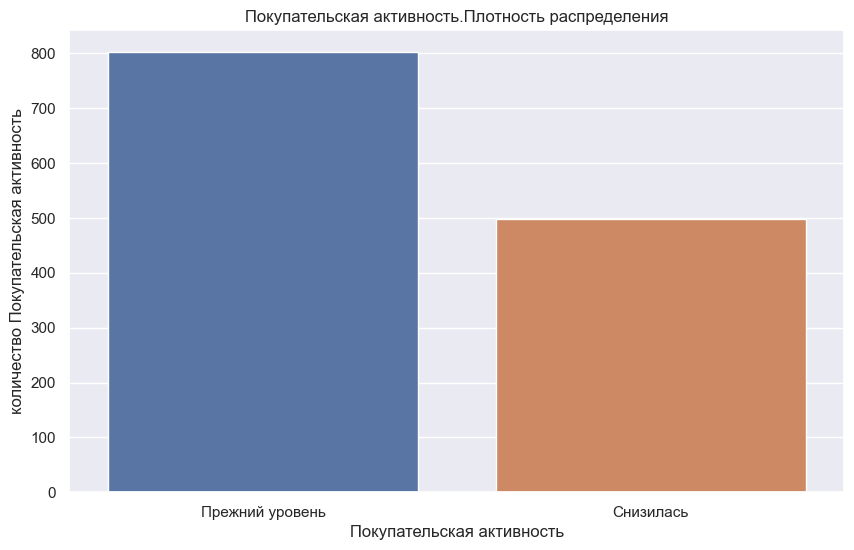

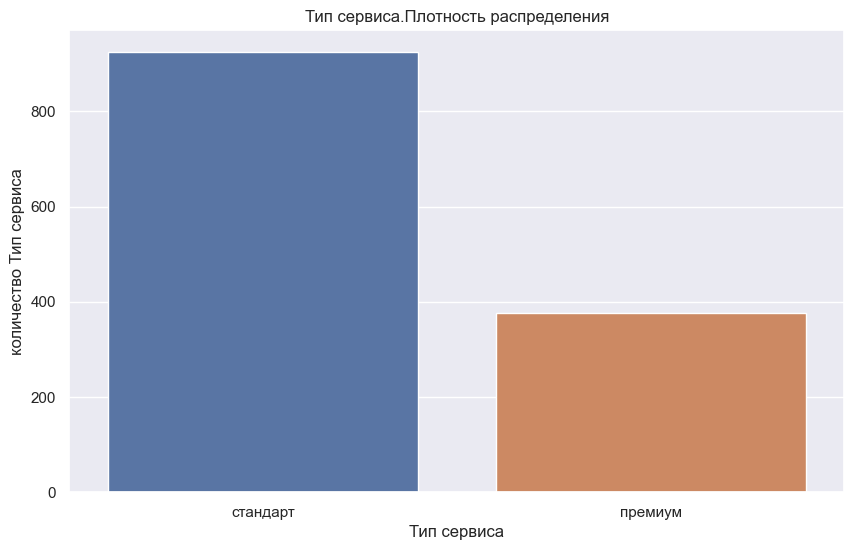

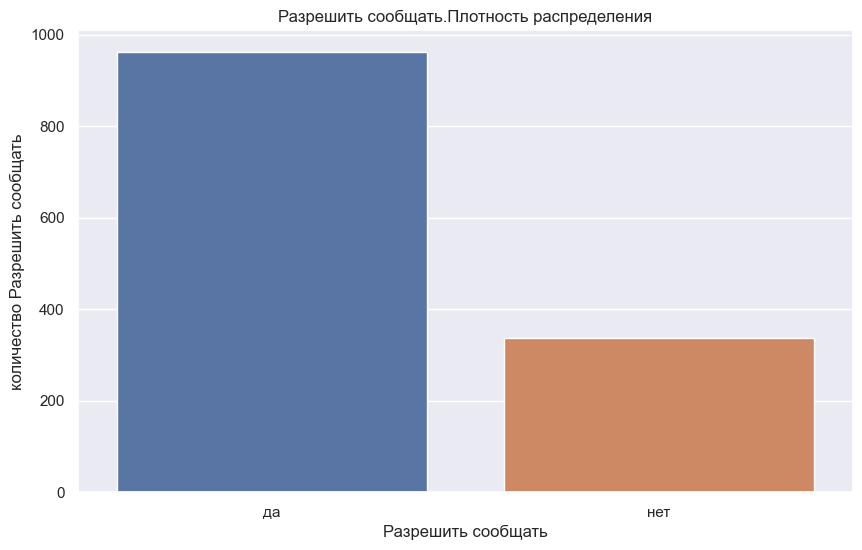

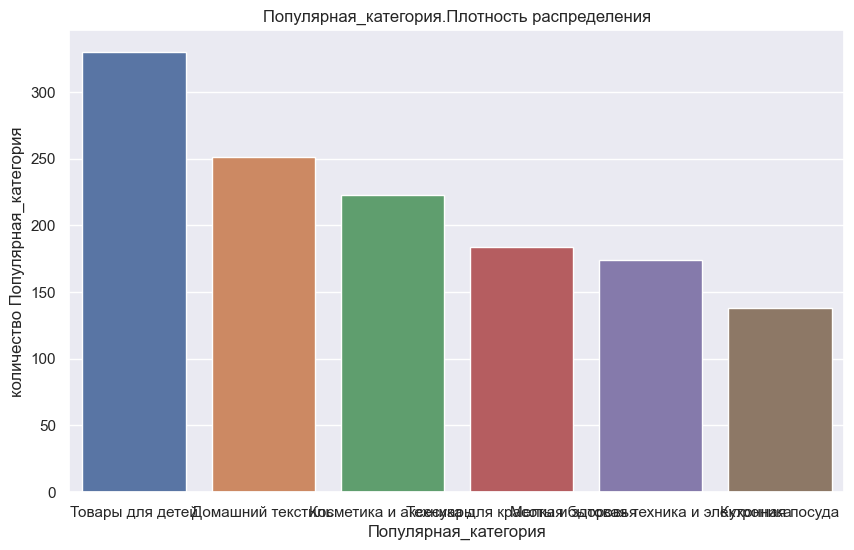

In [206]:
for cat_name in cat_col_names_market:
    create_barplot(df_market_file, cat_name)

df_market_money

In [207]:
df_market_money.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
Выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2


In [208]:
num_col_names_market_money, cat_col_names_market_money = cat_num_col(df_market_money)

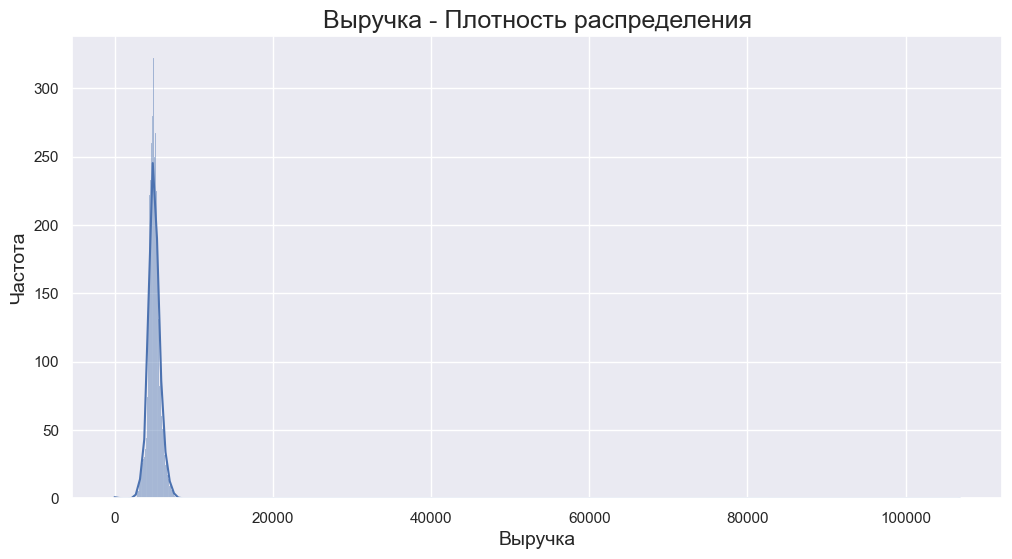

In [209]:
for num_name in num_col_names_market_money:
    create_histogram(df_market_money, num_name,bins=1000)

In [210]:
df_market_money = df_market_money[(df_market_money['Выручка'] <= 20000) & 
                                  (df_market_money['Выручка'] >= 3000) ]


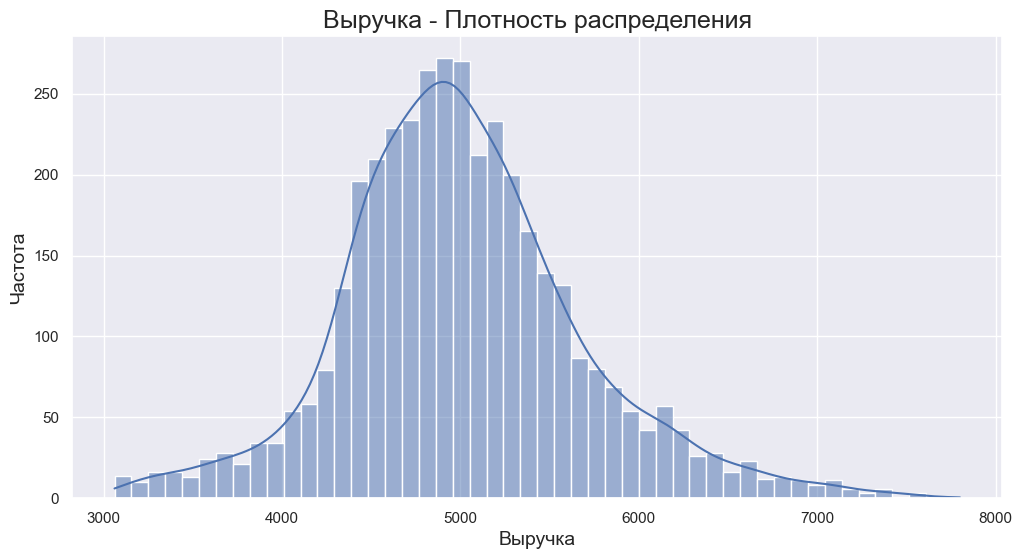

In [211]:
for num_name in num_col_names_market_money:
    create_histogram(df_market_money, num_name,bins=50)

df_market_time

In [212]:
df_market_time.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0


In [213]:
num_col_names_market_time, cat_col_names_market_time = cat_num_col(df_market_time)

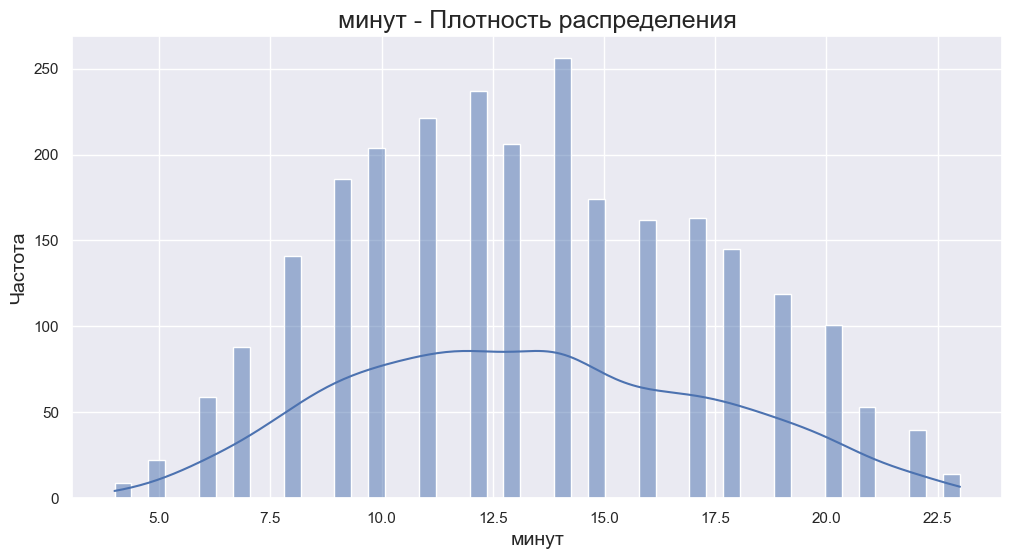

In [214]:
for num_name in num_col_names_market_time:
    create_histogram(df_market_time, num_name,bins=50)

In [215]:
#df_market_money_filtered = df_market_money.loc[(df_market_money['Выручка'] > 0).groupby(df_market_money['id']).transform('all')]
#df_market_file_filtered = df_market_file[df_market_file['id'].isin(df_market_money_filtered['id'])]
#df_market_time_filtered = df_market_time[df_market_time['id'].isin(df_market_money_filtered['id'])]
#df_money_filtered = df_money[df_money['id'].isin(df_market_money_filtered['id'])]


# Этап 4. Объединение таблиц

In [216]:
df_pivot_money = df_market_money.pivot(index='id', columns='Период', values='Выручка')
df_pivot_money.head()

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215348,NaN,NaN,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [217]:
df_pivot_time = df_market_time.pivot(index='id', columns='Период', values='минут')

In [218]:
df_pivot_time.head()

Период,предыдущий_месяц,текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [219]:
df_pivot_time = df_pivot_time.rename(columns={
    'текущий_месяц': 'минут_за_текущий_месяц',
    'предыдущий_месяц': 'минут_за_предыдущий_месяц'
})

In [220]:
df_pivot_money = df_pivot_money.rename(columns={
    'текущий_месяц': 'выручка_за_текущий_месяц',
    'предыдущий_месяц': 'выручка_за_предыдущий_месяц',
    'препредыдущий_месяц': 'выручка_за_препредыдущий_месяц'
})


In [221]:
merged_df = df_market_file.merge(df_pivot_money, on='id', how='left')

In [222]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [223]:
merged_df = merged_df.merge(df_pivot_time, on='id', how='left')

In [224]:
merged_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


In [225]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [226]:
merged_df.duplicated().sum()

0

In [227]:
merged_df.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
выручка_за_предыдущий_месяц            7
выручка_за_препредыдущий_месяц         3
выручка_за_текущий_месяц               3
минут_за_предыдущий_месяц              0
минут_за_текущий_месяц                 0
dtype: int64

In [228]:
merged_df = merged_df.dropna()
merged_df.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
выручка_за_предыдущий_месяц            0
выручка_за_препредыдущий_месяц         0
выручка_за_текущий_месяц               0
минут_за_предыдущий_месяц              0
минут_за_текущий_месяц                 0
dtype: int64

# Этап 5. Корреляционный анализ

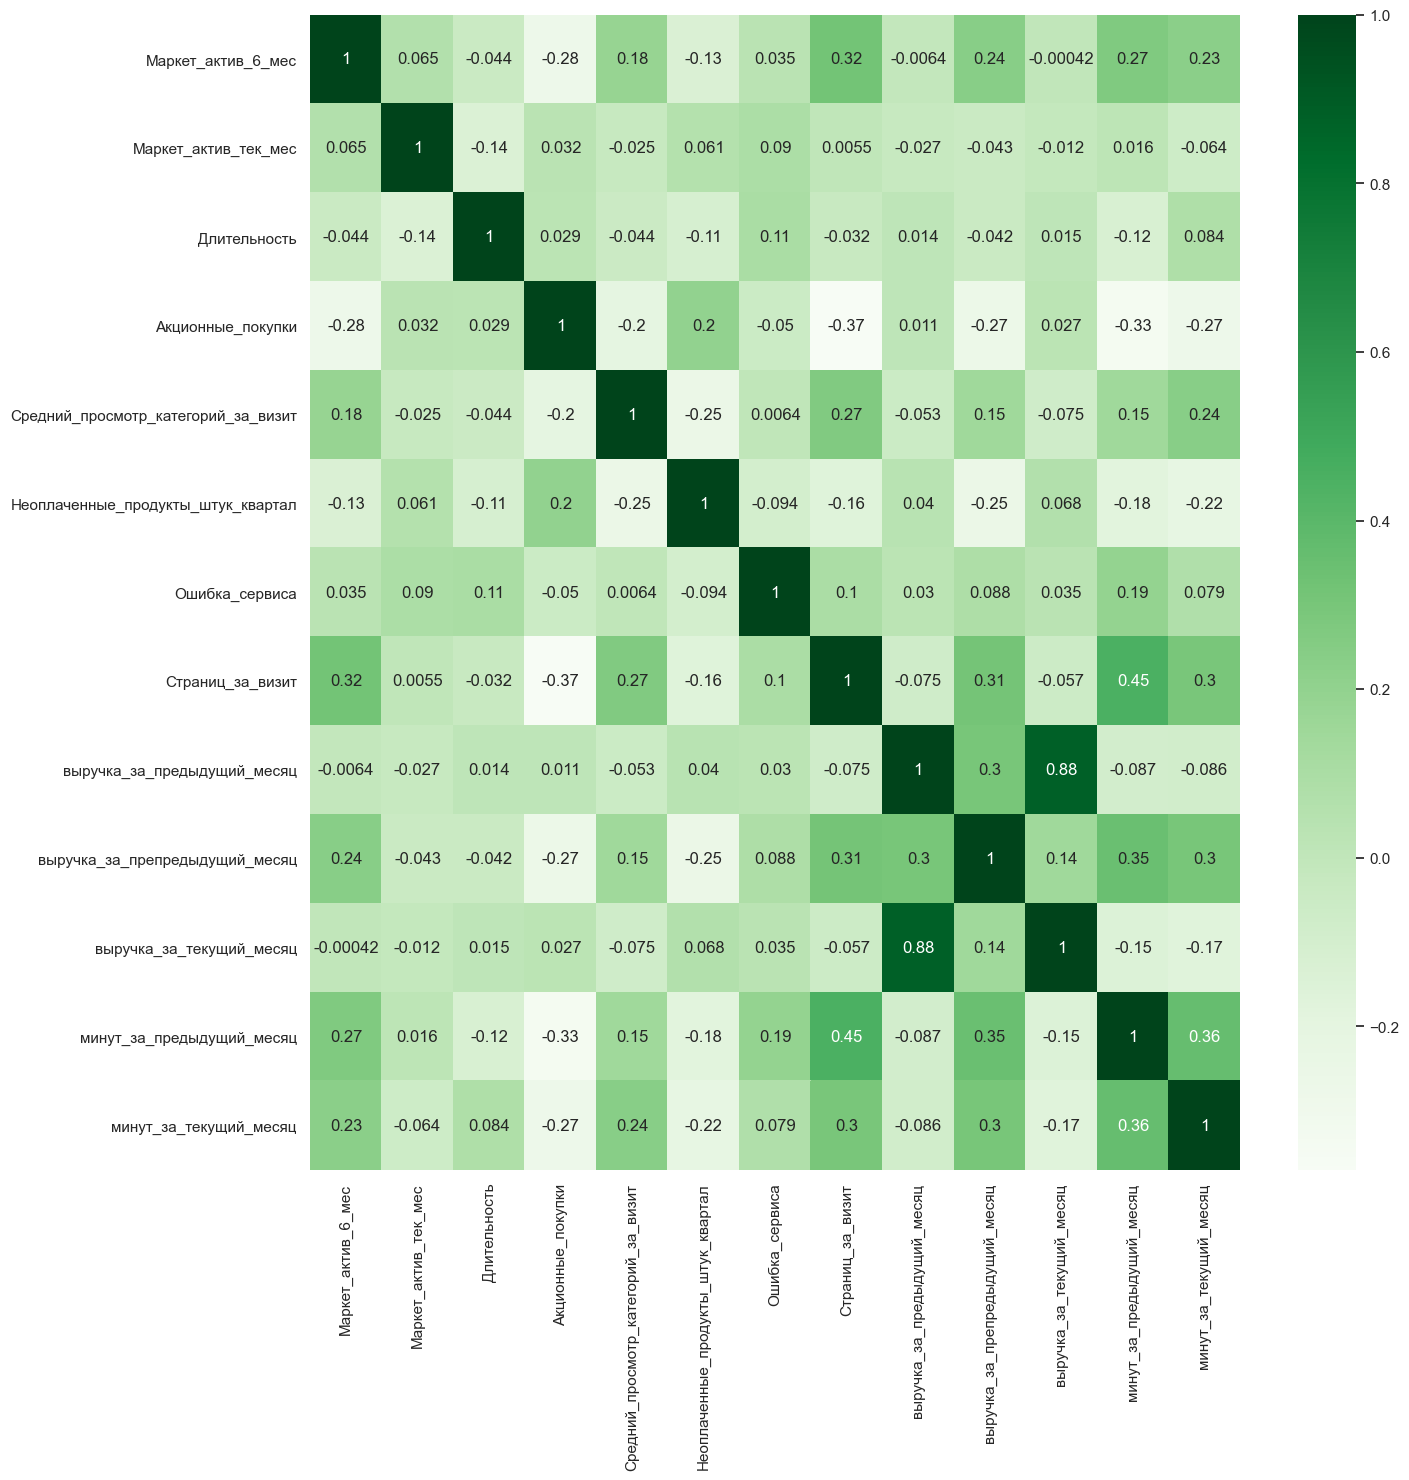

In [229]:
num_col, cat_col = cat_num_col(merged_df)
corr = merged_df[num_col].corr(method = 'spearman')
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, annot = True, cmap="Greens")
None

# Пайплайн 

In [230]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1290 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1290 non-null   int64  
 1   Покупательская активность            1290 non-null   object 
 2   Тип сервиса                          1290 non-null   object 
 3   Разрешить сообщать                   1290 non-null   object 
 4   Маркет_актив_6_мес                   1290 non-null   float64
 5   Маркет_актив_тек_мес                 1290 non-null   int64  
 6   Длительность                         1290 non-null   int64  
 7   Акционные_покупки                    1290 non-null   float64
 8   Популярная_категория                 1290 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1290 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1290 non-null   int64  
 11  Ошибка_сервиса                

In [231]:
merged_df['Покупательская активность'] = merged_df['Покупательская активность'].apply(lambda x: 0 if x == 'Снизилась' else (1 if x == 'Прежний уровень' else x))


In [232]:
ohe_col = ['Популярная_категория']
ord_col = ['Тип сервиса', 'Разрешить сообщать']


In [233]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
X_train, X_test, y_train, y_test = train_test_split(
    merged_df.drop(['Покупательская активность', 'id'], axis=1),
    merged_df['Покупательская активность'],
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify = merged_df['Покупательская активность']
)
matrix =   merged_df.drop(['Покупательская активность', 'id'], axis=1)

In [234]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
        )
    ]
)

ord_pipe = Pipeline([
    (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ('ord',  
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'], 
                    ['нет', 'да'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
    ), 
    (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_col),
        ('ord', ord_pipe, ord_col),
        ('num', StandardScaler(), num_col)
    ], 
    remainder='passthrough'
) 

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [235]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [3, 4, 5],
        'models__min_samples_split': range(1,10),
        'models__min_samples_leaf': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }, 
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': [0.1, 1, 10], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }, 
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 1, 10],
        'models__kernel': ['rbf', 'sigmoid', 'linear', 'poly'], 
        'models__gamma': [0.1, 1, 10],
        'models__degree': [2, 3, 4],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': [3, 5, 7],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }
]

random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE)

random_search.fit(X_train, y_train)
print('Лучшая модель и ее параметры:\n\n', random_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)

pred = random_search.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, pred)}')

/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for t

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
               

# Этап. Оценка важности признаков

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


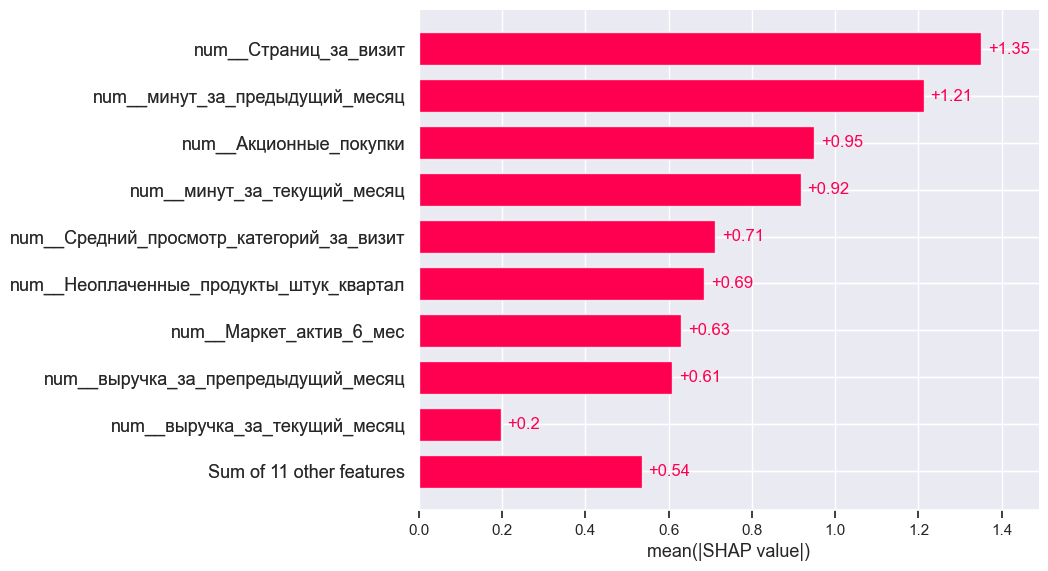

In [236]:
X_train = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
explainer = shap.Explainer(random_search.best_estimator_.named_steps['models'], X_train)

X_test = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test = pd.DataFrame(X_test, columns =feature_names)
shap_values = explainer(X_test)

shap.plots.bar(shap_values)




# Шаг 8. Сегментация покупателей

In [247]:
def shapiro_test(data, column):
    """
    Функция выполняет тест Шапиро-Уилка на нормальность данных в указанном столбце.

    Параметры:
        - data: pandas DataFrame, входные данные
        - column: str, название столбца, для которого выполняется тест

    Вывод:
        - печать результата теста Шапиро-Уилка, включая статистику теста и p-значение
        - вывод сообщения о том, является ли распределение данных нормальным
    """ 
    statistic, p_value = shapiro(data[column])

    # Печать результата теста
    alpha = 0.05  # Уровень значимости
    print(f'Результат теста Шапиро-Уилка для столбца {column}:')
    print(f'Статистика теста: {statistic}')
    print(f'p-значение: {p_value}')
    if p_value > alpha:
        print('Распределение данных является нормальным.')
    else:
        print('Распределение данных не является нормальным.')

In [237]:
merged_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц
1,215349,0,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,0,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,0,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,0,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,0,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [238]:
df_money= df_money[df_money['id'].isin(merged_df['id'])]

In [239]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1290 entries, 1 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1290 non-null   int64  
 1   Прибыль  1290 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 30.2 KB


In [240]:
proba = random_search.predict_proba(matrix)


In [241]:
df_segmentation = df_money.copy()

In [242]:
df_segmentation['вероятность_снижения'] = proba[:, 0]


In [243]:
df_segmentation.head()

,id,Прибыль,вероятность_снижения
1,215349,4.16,0.936296
2,215350,3.13,0.345143
3,215351,4.87,0.862654
4,215352,4.21,0.966206
5,215353,3.95,0.618488


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<Figure size 1000x600 with 0 Axes>

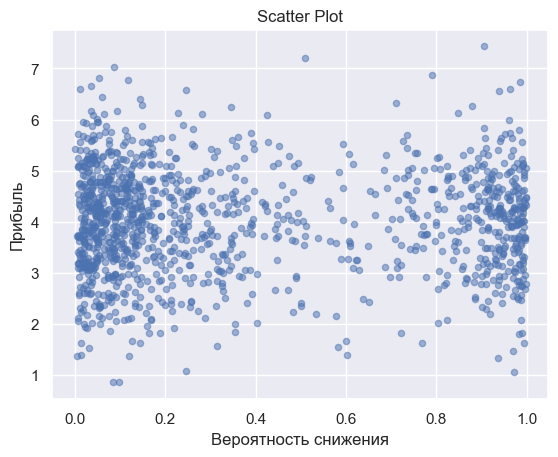

In [246]:
plt.figure(figsize=(10, 6))
df_segmentation.plot(x='вероятность_снижения', y='Прибыль', kind='scatter', alpha=0.5)
plt.title('Scatter Plot')
plt.xlabel('Вероятность снижения')
plt.ylabel('Прибыль')
plt.show()

In [250]:
shapiro_test(df_segmentation, 'вероятность_снижения')
print()
shapiro_test(df_segmentation, 'Прибыль')

Результат теста Шапиро-Уилка для столбца вероятность_снижения:
Статистика теста: 0.8075658679008484
p-значение: 1.2567942349229973e-36
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Прибыль:
Статистика теста: 0.9984753131866455
p-значение: 0.31466591358184814
Распределение данных является нормальным.


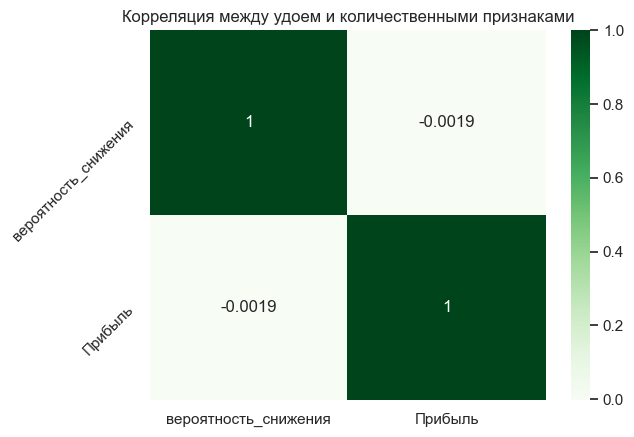

In [253]:
correlation_matrix = df_segmentation[['вероятность_снижения', 'Прибыль']].corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True, cmap='Greens')
plt.yticks(rotation=45)
plt.title(f'Корреляция между удоем и количественными признаками')
plt.show()
